# Frequency Domain Sensitivity Analysis

This notebook demonstrates how to use JAX autodiff with the PyVibrate frequency-domain module
to compute sensitivities of circuit impedance with respect to component parameters.

In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))

import jax.numpy as jnp
from jax import grad, vmap
import numpy as np
import matplotlib.pyplot as plt

from pyvibrate.frequencydomain import Network, R, C, L, ACSource

## Example 1: RC Circuit Sensitivity

Build a simple RC low-pass filter and compute d|Z|/dC across frequency.

In [2]:
# Build RC circuit
net = Network()
net, n1 = net.node("n1")

net, vs = ACSource(net, n1, net.gnd, name="vs", value=1.0)
net, r1 = R(net, n1, net.gnd, name="R1", value=100.0)
net, c1 = C(net, n1, net.gnd, name="C1")  # C provided at solve time

solver = net.compile()

In [3]:
def impedance_magnitude(C_val, omega):
    """Compute |Z| for given C and omega."""
    sol = solver.solve_at(omega, {"C1": C_val})
    z = solver.z_in(sol, vs)
    return jnp.abs(z)

# Gradient of |Z| with respect to C
d_Z_dC = grad(impedance_magnitude, argnums=0)

# Test at a single frequency
C_val = 1e-6  # 1 uF
freq = 1000  # 1 kHz
omega = 2 * np.pi * freq

z_mag = impedance_magnitude(C_val, omega)
sensitivity = d_Z_dC(C_val, omega)

print(f"At f={freq} Hz, C={C_val*1e6:.1f} uF:")
print(f"  |Z| = {z_mag:.2f} ohm")
print(f"  d|Z|/dC = {sensitivity:.2e} ohm/F")

At f=1000 Hz, C=1.0 uF:
  |Z| = 84.67 ohm
  d|Z|/dC = -2.40e+07 ohm/F


In [4]:
# Sweep frequency and compute sensitivity
frequencies = np.logspace(1, 5, 100)  # 10 Hz to 100 kHz
omegas = 2 * np.pi * frequencies

z_magnitudes = []
sensitivities = []

for omega in omegas:
    z_magnitudes.append(float(impedance_magnitude(C_val, omega)))
    sensitivities.append(float(d_Z_dC(C_val, omega)))

z_magnitudes = np.array(z_magnitudes)
sensitivities = np.array(sensitivities)

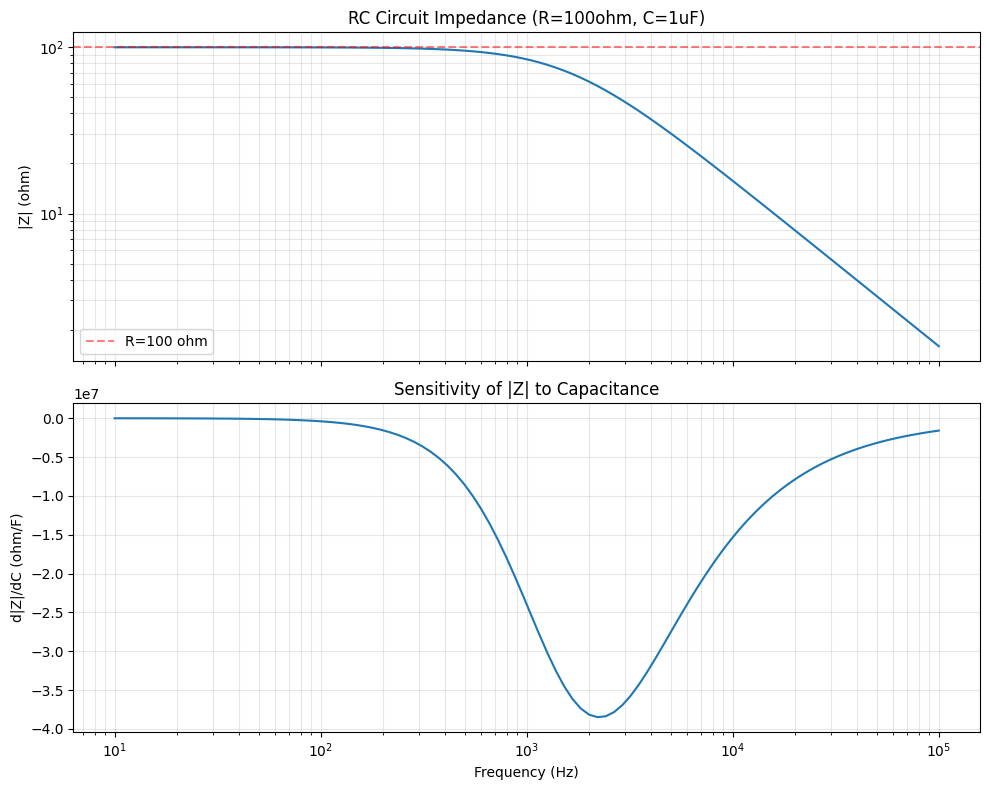


Maximum sensitivity at f = 2205 Hz
  d|Z|/dC = -3.85e+07 ohm/F


In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot impedance magnitude
ax1.loglog(frequencies, z_magnitudes)
ax1.set_ylabel('|Z| (ohm)')
ax1.set_title(f'RC Circuit Impedance (R=100ohm, C={C_val*1e6:.0f}uF)')
ax1.grid(True, which='both', alpha=0.3)
ax1.axhline(100, color='r', linestyle='--', alpha=0.5, label='R=100 ohm')
ax1.legend()

# Plot sensitivity
ax2.semilogx(frequencies, sensitivities)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('d|Z|/dC (ohm/F)')
ax2.set_title('Sensitivity of |Z| to Capacitance')
ax2.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

# Find frequency of maximum sensitivity
max_idx = np.argmin(sensitivities)  # Most negative
print(f"\nMaximum sensitivity at f = {frequencies[max_idx]:.0f} Hz")
print(f"  d|Z|/dC = {sensitivities[max_idx]:.2e} ohm/F")

## Example 2: RLC Resonance Sensitivity

For a series RLC circuit, compute how the resonant impedance changes with L and C.

In [6]:
# Build RLC series circuit
net = Network()
net, n1 = net.node("n1")
net, n2 = net.node("n2")
net, n3 = net.node("n3")

net, vs = ACSource(net, n1, net.gnd, name="vs", value=1.0)
net, r1 = R(net, n1, n2, name="R1", value=10.0)   # 10 ohm series R
net, l1 = L(net, n2, n3, name="L1")                # L provided at solve time
net, c1 = C(net, n3, net.gnd, name="C1")           # C provided at solve time

solver_rlc = net.compile()

In [7]:
def rlc_impedance_mag(L_val, C_val, omega):
    """Compute |Z| for series RLC circuit."""
    sol = solver_rlc.solve_at(omega, {"L1": L_val, "C1": C_val})
    z = solver_rlc.z_in(sol, vs)
    return jnp.abs(z)

# Compute gradients
d_Z_dL = grad(rlc_impedance_mag, argnums=0)
d_Z_dC = grad(rlc_impedance_mag, argnums=1)

# Default values
L_val = 1e-3   # 1 mH
C_val = 1e-6   # 1 uF

# Resonant frequency: f = 1/(2*pi*sqrt(LC))
f_res = 1 / (2 * np.pi * np.sqrt(L_val * C_val))
omega_res = 2 * np.pi * f_res

print(f"Resonant frequency: {f_res:.0f} Hz")
print(f"\nAt resonance (f={f_res:.0f} Hz):")
print(f"  |Z| = {rlc_impedance_mag(L_val, C_val, omega_res):.2f} ohm")
print(f"  d|Z|/dL = {d_Z_dL(L_val, C_val, omega_res):.2e} ohm/H")
print(f"  d|Z|/dC = {d_Z_dC(L_val, C_val, omega_res):.2e} ohm/F")

Resonant frequency: 5033 Hz

At resonance (f=5033 Hz):
  |Z| = 10.00 ohm
  d|Z|/dL = 1.17e-02 ohm/H
  d|Z|/dC = 1.37e+01 ohm/F


In [8]:
# Sweep frequency around resonance
frequencies = np.linspace(f_res * 0.5, f_res * 2, 200)
omegas = 2 * np.pi * frequencies

z_mags = []
dZ_dL = []
dZ_dC = []

for omega in omegas:
    z_mags.append(float(rlc_impedance_mag(L_val, C_val, omega)))
    dZ_dL.append(float(d_Z_dL(L_val, C_val, omega)))
    dZ_dC.append(float(d_Z_dC(L_val, C_val, omega)))

z_mags = np.array(z_mags)
dZ_dL = np.array(dZ_dL)
dZ_dC = np.array(dZ_dC)

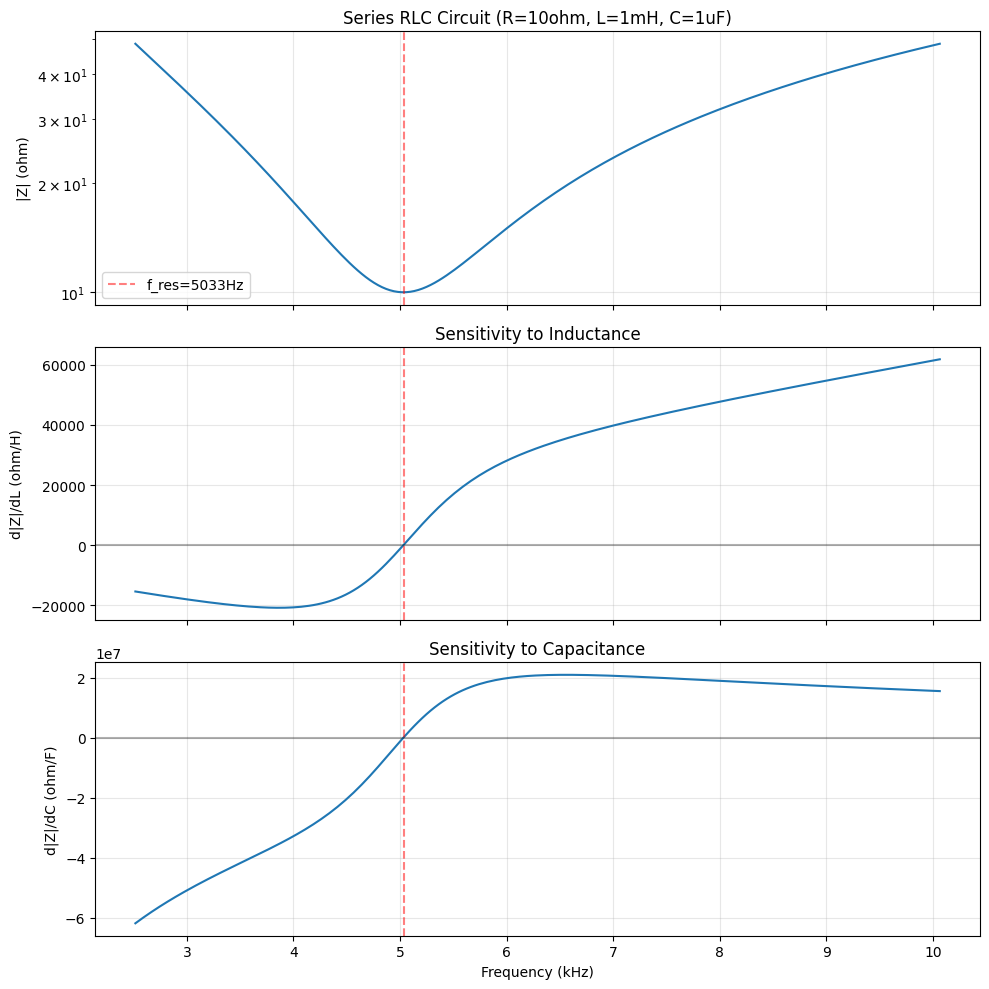

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Impedance
ax1.semilogy(frequencies/1000, z_mags)
ax1.axvline(f_res/1000, color='r', linestyle='--', alpha=0.5, label=f'f_res={f_res:.0f}Hz')
ax1.set_ylabel('|Z| (ohm)')
ax1.set_title(f'Series RLC Circuit (R=10ohm, L={L_val*1e3:.0f}mH, C={C_val*1e6:.0f}uF)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Sensitivity to L
ax2.plot(frequencies/1000, dZ_dL)
ax2.axvline(f_res/1000, color='r', linestyle='--', alpha=0.5)
ax2.axhline(0, color='k', linestyle='-', alpha=0.3)
ax2.set_ylabel('d|Z|/dL (ohm/H)')
ax2.set_title('Sensitivity to Inductance')
ax2.grid(True, alpha=0.3)

# Sensitivity to C
ax3.plot(frequencies/1000, dZ_dC)
ax3.axvline(f_res/1000, color='r', linestyle='--', alpha=0.5)
ax3.axhline(0, color='k', linestyle='-', alpha=0.3)
ax3.set_xlabel('Frequency (kHz)')
ax3.set_ylabel('d|Z|/dC (ohm/F)')
ax3.set_title('Sensitivity to Capacitance')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Interpretation

The sensitivity plots show:

1. **RC Circuit**: At low frequencies (capacitor is high impedance), |Z| doesn't depend much on C.
   At high frequencies, increasing C decreases impedance (d|Z|/dC < 0).

2. **RLC Circuit**: 
   - Below resonance: capacitive region, d|Z|/dC < 0 (more C = lower Z)
   - Above resonance: inductive region, d|Z|/dL > 0 (more L = higher Z)
   - At resonance: minimum impedance (just R), sensitivities near zero

These sensitivities are useful for:
- Understanding which components dominate at different frequencies
- Tolerance analysis (how much does Z change if C varies by 10%?)
- Optimization (gradient descent to match a target impedance)